# Data Loading

### Download dataset dari kaggle

> Pengambilan dataset dari kaggle dilakukan menggunakan API kaggle. Dataset diunduh dengan menuliskan kode dengan format nama_pembuat/nama_dataset. Setelah pengunduhan dataset berhasil, dataset kemudian di unzip dan siap digunakan.

> Pertama-tama, mari install package kaggle terlebih dahulu





In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


> Kemudian mari atur API key kaggle.json

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

> Setelah itu, mari cari dataset yang diinginkan. Saya memilih dataset dengan keyword pencarian 'recommend' untuk proyek sistem rekomendasi saya

In [ ]:
!kaggle datasets list -s recommend

ref                                                  title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
CooperUnion/anime-recommendations-database           Anime Recommendations Database                       25MB  2016-12-21 04:58:34          41425       1093  0.8235294        
hernan4444/anime-recommendation-database-2020        Anime Recommendation Database 2020                  661MB  2021-07-13 19:26:08          10176        381  1.0              
retailrocket/ecommerce-dataset                       Retailrocket recommender system dataset             291MB  2022-11-08 16:03:10          21551        458  0.88235295       
arashnic/book-recommendation-dataset                 Book Recommendation Dataset                          24MB  202

> Pilih salah satu dataset yang muncul dan download dengan format nama_pembuat/nama_dataset. Dataset yang saya pilih adalah dataset yang berjudul *Movie Recommender System Dataset*.

In [ ]:
!kaggle datasets download gargmanas/movierecommenderdataset  --unzip

  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 82.9MB/s]


### Import Library & Data Overview

In [ ]:
# library untuk data
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from PIL import Image

# library untuk content based filtering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

# library untuk collaborative filtering
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

In [ ]:
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')

print(f'Jumlah data movie : {len(movies.movieId.unique())}')
print(f'Jumlah data penilaian movie : {len(ratings.movieId.unique())}')
print(f'Jumlah data pengguna yang memberikan penilaian movie : {len(ratings.userId.unique())}')

Jumlah data movie : 9742
Jumlah data penilaian movie : 9724
Jumlah data pengguna yang memberikan penilaian movie : 610


> Berdasarkan output di atas, maka dapat disimpulkan bahwa data telah berhasil di *import* ke kernel. Setelah ini adalah tahap *univariate exploratory data analysis* 

# Exploratory Data Analysis

> Variabel-variabel pada *Movie Recommender System Dataset* adalah sebagai berikut:
- movies: merupakan data yang berisi mengenai informasi movie
- ratings: merupakan data yang berisi mengenai informasi penilaian movie

> Pada tahap ini, akan dilakukan analisis pada masing-masing variabel *Movie Recommender System Dataset*. Tahap pertama adalah melakukan deskripsi masing-masing variabel.

## Deskripsi Variabel

### Variabel movies

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


> Berdasarkan output di atas, dapat diketahui bahwa file movies.csv memiliki 9742 entri. Variabel-variabel dalam movies.csv adalah sebagai berikut:
- movieId: id movie
- title: judul movie
- genres: daftar genre movie

### Variabel ratings

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


> Berdasarkan output di atas, dapat diketahui bahwa file ratings.csv memiliki 100836 entri. Variabel-variabel dalam ratings.csv adalah sebagai berikut:
- userId: id pengguna
- movieId: id movie
- rating: jumlah penilain movie terhadap pengguna
- timestamp: waktu ketika entri diciptakan yang berbentuk detik sejak 1 Januari 1970

> Tahap selanjutnya setelah deskripsi variabel adalah *data cleaning*

## Data Cleaning

> Tahap pertama adalah melakukan penggabungan antara variabel movies dan ratings.

In [ ]:
df = ratings.merge(movies, on="movieId")
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


> Selanjutnya mari kita cek terlebih dahulu deskripsi dari df.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


> Berdasarkan info diatas, maka dapat disimpulkan dataframe df, hasil penggabungan antara movies dan ratings sekarang memiliki 6 kolom yang semuanya berjumlah 100836 entri. Selanjutnya mari kita cek deskripsi kolom numerik dari dataframe df.

In [ ]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


> Berdasarkan deskripsi kolom numerik, sepertinya tidak ada yang bermasalah. Selanjutnya kita cek apakah terdapat *missing value*

In [ ]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

> Sepertinya juga tidak ada *missing value*. Selanjutnya kita periksa kolom title

In [ ]:
df.title

0                         Toy Story (1995)
1                         Toy Story (1995)
2                         Toy Story (1995)
3                         Toy Story (1995)
4                         Toy Story (1995)
                        ...               
100831                    Bloodmoon (1997)
100832    Sympathy for the Underdog (1971)
100833                       Hazard (2005)
100834                  Blair Witch (2016)
100835                           31 (2016)
Name: title, Length: 100836, dtype: object

> Berdasarkan output di atas, judul movie masih digabung dengan tahun movie. Mari pisahkan judul dan tahun ini.

In [ ]:
df['year'] = df.title.str.extract('.*\((.*)\).*')
df['title'] = df.title.str.split('(').str[0].str[:-1]
df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


> Sekarang coba cek kembali informasi mengenai dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
 6   year       100819 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 6.2+ MB


> Berdasarkan output diatas, ternyata masih ada keanehan, yaitu pada fitur year. Seharusnya fitur tersebut bertipe int64 karena merupakan kolom numerik, tetapi bertipe object, mari periksa fitur tersebut.

In [ ]:
df.year.unique()

array(['1995', '1996', '1994', '1977', '1993', '1990', '1989', '1991',
       '1940', '1939', '1941', '1938', '1947', '1975', '1968', '1945',
       '1963', '1971', '1951', '1979', '1992', '1986', '1982', '1980',
       '1987', '1981', '1983', '1960', '1952', '1984', '1933', '1985',
       '1974', '1922', '1997', '1998', '1930', '1976', '1942', '1967',
       '1959', '1946', '1978', '1973', '1988', '1999', '1931', '1964',
       '1962', '1965', '1969', '2000', '1970', '2003', '2004', '2006',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '1955', '2002', '1961', '1954', '1957', '1943', '1956', '1966',
       '2001', '1937', '1972', '2005', '1950', '2007', '2016', '1926',
       '1944', '1949', '1936', '2017', '1958', '1935', '1927', '1953',
       '2018', '1923', '1902', '1920', '1948', '1928', nan, '1934',
       '1916', '1908', '1932', '1921', '1925', '1929', '1917',
       '2006–2007', '1915', '1924', '1903', '1919'], dtype=object)

> Ternyata ada kolom yang terisi dengan nan dan 2006-2007. mari atasi nilai nan terlebih dahulu

In [ ]:
df.dropna(inplace=True)

> Setelah itu mari atasi tahun yang bernilai 2006-2007

In [ ]:
df.drop(index=df[df.year.str.len() > 5].index, inplace=True)

> Kemudian kita ubah tipe data kolom year menjadi int64

In [ ]:
df.year = df.year.astype('int64')

> Mari cek kembali deskripsi df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100818 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100818 non-null  int64  
 1   movieId    100818 non-null  int64  
 2   rating     100818 non-null  float64
 3   timestamp  100818 non-null  int64  
 4   title      100818 non-null  object 
 5   genres     100818 non-null  object 
 6   year       100818 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 6.2+ MB


Sepertinya dataset sekarang sudah rapi dan bersih. Tahap selanjutnya adalah Analisis fitur df.

## Analisis

### Jumlah frekuensi ratings

In [ ]:
rating_val_count = df.rating.value_counts()
fig = px.bar(rating_val_count, x=rating_val_count.index, y=rating_val_count, text=rating_val_count,
             labels={
                 "index": "Ratings",
                 'y': 'Number of Ratings'},
             color=rating_val_count,
             width=800, height=400
             )
fig.update_traces(textposition='outside')
fig.update_layout(title_text='Frequency of the Ratings',
                  title_x=0.5, title_font=dict(size=24))
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

> Berdasarkan visualisasi diatas, kebanyakan pengguna melakukan penilaian movie sebanyak 4. Dapat disimpulkan juga, fitur rating berkisar antara 1 hingga 5

### Jumlah frekuensi ratings per movie

In [ ]:
_ = df.title.value_counts()
fig = px.histogram(_, x=_, opacity=0.85, marginal='box',
                   labels={
                       'x': 'Number of Ratings taken'},
                   width=800, height=400)
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))
fig.update_layout(title_text='Distribution of the Number of Ratings taken by the Movies',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

> Berdasarkan visualisasi diatas, dapat disimpulkan bahwa rata-rata jumlah movie yang diberikan rating oleh pengguna adalah sekitar 3000. Ada juga jumlah movie yang diberikan rating dibawah 10. Movie tersebut akan saya drop karena sepertinya tidak berpengaruh terhadap sistem rekomendasi.

In [ ]:
movieFrequency_greater_10 = df['movieId'].value_counts()[df['movieId'].value_counts() >= 10].index
df = df[df.movieId.isin(movieFrequency_greater_10)]

print("Jumlah minimal rated movies setelah proses drop:", df.title.value_counts().nsmallest(5))

Jumlah minimal rated movies setelah proses drop: Skulls, The          10
Doom                 10
Urban Legend         10
Detroit Rock City    10
Fast Five            10
Name: title, dtype: int64


> Dapat terlihat bahwa sekarang rated movie terkecil adalah Fast Five, yaitu berjumlah 10

### Jumlah frekuensi movie berdasarkan genre

In [ ]:
genres_value_counts = df['genres'].str.split('|', expand=True).stack().value_counts()
fig = px.bar(genres_value_counts, x=genres_value_counts.index, y=genres_value_counts, text=genres_value_counts,
             labels={
                 "index": "Genres",
                 'y': 'Frequency'},
             color=genres_value_counts,
             width=800, height=400
             )
fig.update_traces(textposition='outside')
fig.update_layout(title_text='Top Frequent the Movie Genres',
                  title_x=0.5, title_font=dict(size=24))
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

> Berdasarkan visualisasi diatas, maka dapat terlihat genre drama adalah genre dengan jumlah terbanyak dan paling sedikit adalah documentary.

> Berdasarkan hasil analisis, maka dapat disimpulkan beberapa hal berikut
- Jarak rating berkisar antara 0.5 hingga 5
- Rating terbanyak berada pada jumlah rating 4
- Rata-rata user melakukan rating terhadap movie adalah sekitar 3000 kali
- Movie yang diberi rate kurang dari 10 kali dihapus karena tidak akan berpengaruh terhadap sistem rekomendasi
- Movie bergenre drama adalah genre movie yang paling banyak, sedangkan movie bergenre documentary adalah genre movie yang paling sedikit.

> Sebelum melangkah ke tahap selanjutnya, mari cek terlebih dahulu kondisi dataset sekarang.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81116 entries, 0 to 96234
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     81116 non-null  int64  
 1   movieId    81116 non-null  int64  
 2   rating     81116 non-null  float64
 3   timestamp  81116 non-null  int64  
 4   title      81116 non-null  object 
 5   genres     81116 non-null  object 
 6   year       81116 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 7.0+ MB


In [ ]:
df.describe()

,userId,movieId,rating,timestamp,year
count,81116.000000,81116.000000,81116.000000,8.111600e+04,81116.000000
mean,318.989977,14857.178078,3.573678,1.197217e+09,1994.385571
std,181.748877,29539.336412,1.018590,2.167182e+08,13.233176
min,1.000000,1.000000,0.500000,8.281246e+08,1922.000000
25%,167.000000,1007.000000,3.000000,1.001562e+09,1990.000000
50%,316.000000,2471.000000,4.000000,1.180447e+09,1996.000000
75%,474.000000,6016.000000,4.000000,1.431955e+09,2002.000000
max,610.000000,187593.000000,5.000000,1.537799e+09,2018.000000


> Fyuhhh... sepertinya sekarang dataset sudah aman, rapi, dan bersih sehingga dapat disimpulkan bahwa tahap EDA kini telah selesai. Selanjutnya mari ke tahap selanjutnya, yaitu *data preparation*

# Data Preparation

> Pada proyek ini, terdapat tiga jenis sistem rekomendasi yang ingin saya bangun. Sistem rekomendasi tersebut adalah sebagai berikut
- Non-personalized recommendation
- Content-based recommendation
- Collaborative recommendation

> Masing-masing dari ketiga sistem rekomendasi di atas membutuhkan kombinasi dataset dengan formasi yang berbeda. Fokus dari tahap ini adalah membangun dataset untuk ketiga sistem rekomendasi di atas.

## Preprocessing

### Non-personalized recommendation

> Non-personalized recommendation merupakan sistem rekomendasi yang tidak membutuhkan fitur spesifik. Sistem rekomendasi ini biasanya digunakan pada *homepage* aplikasi. Sebagai contoh adalah produk terpopuler pada *homepage* aplikasi *e-commerce*. Dataset yang dibutuhkan pada sistem rekomendasi ini adalah dataset yang memiliki sorting descending dalam fitur populer. Untuk membuat dataset sesuai dengan kondisi tersebut, maka fitur yang dibutuhkan hanyalah fitur title dan rating saja. Langsung saja kita buat dataframe baru

In [ ]:
non_personalized_df = df[['title', 'rating']].copy()
non_personalized_df.head()

,title,rating
0,Toy Story,4.0
1,Toy Story,4.0
2,Toy Story,4.5
3,Toy Story,2.5
4,Toy Story,4.5


> Berdasarkan output diatas, kita sudah berhasil mengekstrak fitur title dan rating pada dataset non_personalized_df untuk sistem rekomendasi pertama kita. Namun, perlu dilihat bahwa sepertinya terdapat duplikat entri, oleh karena itu, mari bersihkan terlebih dahulu hal tersebut.

In [ ]:
non_personalized_df.drop_duplicates(inplace=True)
non_personalized_df.head()

,title,rating
0,Toy Story,4.0
2,Toy Story,4.5
3,Toy Story,2.5
5,Toy Story,3.5
8,Toy Story,3.0


> Okeee...sudah beres. Sekarang mari lanjut ke tahap selanjutnya, yaitu membuat dataset untuk sistem rekomendasi kedua, content based recommendation

### Content-based recommendation

> Content-based recommendation merupakan sebuah sistem rekomendasi yang menggunakan kesamaan fitur sebagai dasar rekomendasi. Sistem rekomendasi ini merekomendasikan item yang mirip dengan yang direferensikan pengguna di masa lalu. Kategori item yang mirip dalam kasus proyek ini dapat direferensikan dari genre movie. Untuk memenuhi kondisi tersebut, dataset yang dibutuhkan pada sistem rekomendasi ini adalah dataset yang berisi mengenai informasi genre movie. Untuk memenuhi kondisi tersebut, maka fitur yang dibutuhkan adalah fitur genre dari dataframe df. Langsung gasken buat dataset genre :).

In [ ]:
title_genres = df[['movieId' ,'title', 'genres', 'year']].drop_duplicates(subset='title').reset_index().drop(columns='index')
genres = []
for genre in title_genres.genres:
    genres = genres + [(genre.replace(' ', '_').replace('|', ' '))]
pd.Series(genres).head(5)

0    Adventure Animation Children Comedy Fantasy
1                                 Comedy Romance
2                          Action Crime Thriller
3                               Mystery Thriller
4                         Crime Mystery Thriller
dtype: object

> Dataset untuk content-based recommendation telah selesai dibuat, selanjutnya mari buat dataset untuk collaborative recommendation

### Collaborative Recommendation

> Collaborative recommendation merupakan sistem rekomendasi yang menggunakan pendapat komunitas atau pengguna terhadap suatu produk sebagai dasar rekomendasi. Sistem rekomendasi ini akan merekomendasikan produk yang kira-kira disukai pengguna lain berdasarkan pendapat pengguna lain dengan kesukaan yang sama. Dataset yang dibutuhkan dalam sistem rekomendasi ini adalah dataset yang memuat informasi mengenai rating movie serta beberapa fitur seperti id user dan id movie. Tahap pertama yang dilakukan untuk memenuhi kondisi tersebut adalah membuat dataset collaborative yang berisi id user, id movie, dan rating.

In [ ]:
collaborative = df[['userId', 'movieId', 'rating']].copy()

> Dataframe collaborative berhasil dibuat, lanjut ke tahap selanjutnya, yaitu melakukan encode id user

In [ ]:
user_ids = collaborative['userId'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

> Selanjutnya, lakukan hal yang sama pada id movie

In [ ]:
movie_ids = collaborative['movieId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

> Selanjutnya, mari lakukan mapping encode diatas pada dataframe collaborative

In [ ]:
collaborative['user'] = collaborative['userId'].map(user_to_user_encoded)
collaborative['movie'] = collaborative['movieId'].map(movie_to_movie_encoded)

> Sebelum lanjut ke tahap selanjutnya, mari coba cek hasil dataframe collaborative sekarang

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah movie
num_movie = len(movie_encoded_to_movie)
print(num_movie)
 
# Nilai minimum rating
min_rating = min(collaborative['rating'])
 
# Nilai maksimal rating
max_rating = max(collaborative['rating'])
 
print('Number of User: {}, Number of movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

610
2269
Number of User: 610, Number of movie: 2269, Min Rating: 0.5, Max Rating: 5.0


> Okee... selanjutnya mari kita acak sampel dataframe collaborative sebelum melakukan pembagian data

In [ ]:
collaborative = collaborative.sample(frac=1, random_state=42)
collaborative

,userId,movieId,rating,user,movie
52039,599,1374,3.0,204,926
16228,367,3809,5.0,131,209
71258,45,2311,4.0,15,1529
65637,522,4734,3.5,178,1338
67623,282,63082,4.0,104,1403
...,...,...,...,...,...
6303,391,1089,5.0,140,57
56237,484,74789,4.0,169,1033
82651,285,3262,3.0,504,1963
860,17,110,4.5,4,7


> Selanjutnya, mari kita lakukan pembagian sampel menjadi data latih dan data validasi dengan rasio 90:10. Perbandingan tersebut dilakukan berdasarkan pertimbangan mengenai jumlah entri dalam dataset yang sangat banyak.

In [ ]:
x = collaborative[['user', 'movie']].values
y = collaborative['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.9 * collaborative.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 204  926]
 [ 131  209]
 [  15 1529]
 ...
 [ 504 1963]
 [   4    7]
 [ 107  203]] [0.55555556 1.         0.77777778 ... 0.55555556 0.88888889 0.77777778]


> Sekarang data untuk collaborative recommendations telah siap. Tahap selanjutnya adalah modelling

# Modelling

> Pada tahap ini akan dibuat fungsi dan class yang berperan sebagai model untuk sistem rekomendasi yang akan diterapkan dalam proyek ini. Masing-masing fungsi dan class tersebut akan menggunakan dataset khusus yang telah dibuat dan disiapkan pada tahap *data preparation*.

## Non personalized recommendation

> Pada sistem rekomendasi ini, akan dibuat sebuah fungsi yang bertugas untuk memilih buku terpopuler. Buku terpopuler ditentukan berdasarkan jumlah rating pengguna terhadap suatu buku dan rata-rata ratingnya. Penjelasan detail mengenai algoritma fungsi akan dibahas di laporan proyek.

In [ ]:
def popular_movies(data,n=100):
    rating_count=data.groupby("title").count()["rating"].reset_index()
    rating_count.rename(columns={"rating":"numberOfVotes"},inplace=True)
    
    rating_average=data.groupby("title")["rating"].mean().reset_index()
    rating_average.rename(columns={"rating":"averageRatings"},inplace=True)
    
    popularMovies=rating_count.merge(rating_average,on="title")
    
    def weighted_rate(x):
        v=x["numberOfVotes"]
        R=x["averageRatings"]
        
        return ((v*R) + (m*C)) / (v+m)
    
    C=popularMovies["averageRatings"].mean()
    m=popularMovies["numberOfVotes"].quantile(0.90)
    
    popularMovies["popularity"]=popularMovies.apply(weighted_rate,axis=1)
    popularMovies=popularMovies.sort_values(by="popularity",ascending=False)
    return popularMovies[["title","numberOfVotes","averageRatings","popularity"]].reset_index(drop=True).head(n)

> Model untuk non personalized recommendation telah dibuat, selanjutnya adalah pembuatan model untuk content-based recommendation

## Content-based recommendation

> Sistem rekomendasi ini dibangun dengan menggunakan teknik count vectorizer. Teknik tersebut digunakan untuk menemukan representasi fitur penting berdasarkan frekuensi kemunculan nilai terbanyak. Setelah representasi fitur dan korelasi antar fitur sudah diketahui, akan dicari derajat kesamaan antar fitur menggunakan teknik cosine similarity. Penjelasan detail mengenai algoritma fungsi akan dijelaskan pada laporan proyek.

> Langkah pertama dalam pembuatan model untuk content based adalah membuat count vectorizer movie berdasarkan genres.

### Count vectorizer

In [ ]:
cv = CountVectorizer()
sparse_m = cv.fit_transform(genres)
features = cv.get_feature_names_out()
count_table = pd.DataFrame(sparse_m.toarray(), columns = features, index = title_genres.title)
print(features)
count_table

['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi' 'film' 'horror' 'imax' 'musical'
 'mystery' 'noir' 'romance' 'sci' 'thriller' 'war' 'western']


,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Grumpier Old Men,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Heat,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Seven,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
"Usual Suspects, The",0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
John Carter,1,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
"Amityville Horror, The",0,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
Christine,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


> Berdasarkan output diatas, representasi fitur movie berdasarkan genres telah berhasil dibuat. Langkah selanjutnya adalah membuat fungsi yang berperan sebagai model untuk menentukan derajat kesamaan antar fitur.

### Cosine similarity

In [ ]:
def content_based_genre_by_user(userId):
    by_time = df[df.userId == userId].sort_values(by='timestamp', ascending=False).iloc[:3]
    user_pref = pd.concat([df, by_time.title.apply(lambda title: count_table.loc[title, :])], axis = 1)
    total_user_pref = user_pref.groupby('userId').sum().iloc[:,4:]
    similarity = {}
    for row in count_table.index:
        similarity[row] = float( cosine_similarity( pd.DataFrame(count_table.loc[row]).T, pd.DataFrame(total_user_pref.loc[userId]).T ) )
    similarity = pd.Series(similarity)
    return title_genres[title_genres.title.isin(similarity.sort_values(ascending=False)[:10].index)]

> Model untuk content-based recommendation telah dibuat, selanjutnya adalah pembuatan model untuk collaborative recommendation

## Collaborative recommendation

> Sistem rekomendasi ini dibangun dengan membuat class baru dengan Keras model. Class baru tersebut bernama CollRecNet. Penjelasan lebih detail mengenai CollRecNet akan dijelaskan pada laporan proyek. Langkah pertama, mari buat terlebih dahulu class CollRecNet.

In [ ]:
class CollRecNet(tf.keras.Model):

  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(CollRecNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.movies_embedding = layers.Embedding(
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movies_bias = layers.Embedding(num_movies, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movies_vector = self.movies_embedding(inputs[:, 1])
    movies_bias = self.movies_bias(inputs[:, 1])

    dot_user_movies = tf.tensordot(user_vector, movies_vector, 2)

    x = dot_user_movies + user_bias + movies_bias
    
    return tf.nn.sigmoid(x)

> Selanjutnya mari kita compile model CollRecNet

In [ ]:
model = CollRecNet(num_users, num_movie, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

> Langkah berikutnya adalah memulai proses training

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
9126/9126 [==============================] - 51s 5ms/step - loss: 0.6175 - root_mean_squared_error: 0.2198 - val_loss: 0.5995 - val_root_mean_squared_error: 0.2004
Epoch 2/20
9126/9126 [==============================] - 36s 4ms/step - loss: 0.5946 - root_mean_squared_error: 0.1949 - val_loss: 0.5962 - val_root_mean_squared_error: 0.1967
Epoch 3/20
9126/9126 [==============================] - 37s 4ms/step - loss: 0.5906 - root_mean_squared_error: 0.1902 - val_loss: 0.5944 - val_root_mean_squared_error: 0.1944
Epoch 4/20
9126/9126 [==============================] - 34s 4ms/step - loss: 0.5884 - root_mean_squared_error: 0.1876 - val_loss: 0.5931 - val_root_mean_squared_error: 0.1926
Epoch 5/20
9126/9126 [==============================] - 37s 4ms/step - loss: 0.5873 - root_mean_squared_error: 0.1862 - val_loss: 0.5939 - val_root_mean_squared_error: 0.1934
Epoch 6/20
9126/9126 [==============================] - 35s 4ms/step - loss: 0.5869 - root_mean_squared_error: 0.1856 - val_l

> Fyuuhhhh... akhirnya modelling untuk seluruh sistem remondasi berhasil dilakukan. Langkah selanjutnya adalah evaluasi

# Evaluasi

## Non personalized recommendation

> Pada tahap ini, akan didapatkan hasil rekomendasi dari fungsi popular_books yang telah dibuat

In [ ]:
popular_movies(non_personalized_df, n=10)

,title,numberOfVotes,averageRatings,popularity
0,Elite Squad,4,4.25,3.489816
1,His Girl Friday,4,4.25,3.489816
2,Living in Oblivion,4,4.25,3.489816
3,Fog of War: Eleven Lessons from the Life of Ro...,4,4.25,3.489816
4,Creature Comforts,4,4.25,3.489816
5,Persepolis,4,4.25,3.489816
6,Seven Pounds,4,4.25,3.489816
7,Paths of Glory,4,4.25,3.489816
8,Rope,4,4.25,3.489816
9,All Quiet on the Western Front,4,4.25,3.489816


> Berdasarkan output diatas, dapat terlihat daftar movie terpopuler. Movie terpopuler adalah Elite Squad dengan nilai popularity 3.48. Hasil dari sistem rekomendasi ini biasanya akan digunakan untuk *homepage* aplikasi sesuai dengan yang telah dijelaskan pada tahap *data preparation*. Sistem rekomendasi ini merekomendasikan item tidak berdasarkan suatu fitur, sehingga pada sistem rekomendasi ini tidak dilakukan pengukuran performa evaluasi.

> Langkah selanjutnya adalah melakukan evaluasi terhadap content based recommendation

## Content based recommendation

> Pertama, mari cek dulu, hasil rekomendasi dari fungsi content\_based\_genres\_by\_user

In [ ]:
content_based_genre_by_user(125)

,movieId,title,genres,year
814,48774,Children of Men,Action|Adventure|Drama|Sci-Fi|Thriller,2006
831,91500,The Hunger Games,Action|Adventure|Drama|Sci-Fi|Thriller,2012
956,5944,Star Trek: Nemesis,Action|Drama|Sci-Fi|Thriller,2002
972,8361,"Day After Tomorrow, The",Action|Adventure|Drama|Sci-Fi|Thriller,2004
1045,87232,X-Men: First Class,Action|Adventure|Sci-Fi|Thriller|War,2011
1047,88140,Captain America: The First Avenger,Action|Adventure|Sci-Fi|Thriller|War,2011
1057,103772,"Wolverine, The",Action|Adventure|Fantasy|Sci-Fi,2013
1391,58025,Jumper,Action|Adventure|Drama|Sci-Fi|Thriller,2008
1436,117529,Jurassic World,Action|Adventure|Drama|Sci-Fi|Thriller,2015
1698,136864,Batman v Superman: Dawn of Justice,Action|Adventure|Fantasy|Sci-Fi,2016


> Output diatas merupakan daftar movie yang direkomendasikan kepada pengguna yang memiliki id 125. Movie diatas direkomendasikan berdasarkan genre movie yang disukai oleh pengguna. Setelah ini akan dilakukan evaluasi menggunakan matriks *normalized discount cumulative gain* atau biasa disebut NDCG.

### Evaluasi content based menggunakan NDCG

> Pertama, mari kita buat fungsi untuk mendapatkan daftar movie yang pernah diberikan rating oleh pengguna berdasarkan preferensi masa lalu.

In [ ]:
def get_movie_preference_by_user(userId):
  by_time = df[df.userId == userId].sort_values(by='timestamp', ascending=False).iloc[3:6]
  user_pref = pd.concat([df, by_time.title.apply(lambda title: count_table.loc[title, :])], axis = 1)
  total_user_pref = user_pref.groupby('userId').sum().iloc[:,4:]
  similarity = {}
  for row in count_table.index:
      similarity[row] = float( cosine_similarity( pd.DataFrame(count_table.loc[row]).T, pd.DataFrame(total_user_pref.loc[userId]).T ) )
  similarity = pd.Series(similarity)
  return title_genres[title_genres.title.isin(similarity.sort_values(ascending=False)[:10].index)]

> Setelah membuat fungsi diatas, mari kita coba hasil preferensi movie pengguna.

In [ ]:
get_movie_preference_by_user(125)

,movieId,title,genres,year
593,5378,Star Wars: Episode II - Attack of the Clones,Action|Adventure|Sci-Fi|IMAX,2002
616,8636,Spider-Man 2,Action|Adventure|Sci-Fi|IMAX,2004
719,72998,Avatar,Action|Adventure|Sci-Fi|IMAX,2009
732,95510,"Amazing Spider-Man, The",Action|Adventure|Sci-Fi|IMAX,2012
830,89745,"Avengers, The",Action|Adventure|Sci-Fi|IMAX,2012
838,110102,Captain America: The Winter Soldier,Action|Adventure|Sci-Fi|IMAX,2014
1054,102445,Star Trek Into Darkness,Action|Adventure|Sci-Fi|IMAX,2013
1887,82461,Tron: Legacy,Action|Adventure|Sci-Fi|IMAX,2010
1896,106002,Ender's Game,Action|Adventure|Sci-Fi|IMAX,2013
2236,93363,John Carter,Action|Adventure|Sci-Fi|IMAX,2012


> Berdasarkan hasil output diatas, maka terlihat bahwa terdapat beberapa movie yang memiliki genre mirip seperti hasil rekomendasi diatas. Baik, langkah selanjutnya mari kita hitung NDCG skor dengan melakukan perbandingan hasil rekomendasi dan preferensi pengguna. Untuk memudahkan, mari kita buat fungsi ndcg_result.

In [ ]:
def ndcg_result(userId):
  rec_2 = np.asarray([content_based_genre_by_user(userId).movieId.values])
  rec_1 = np.asarray([get_movie_preference_by_user(userId).movieId.values])
  print(f'NDCG score : {ndcg_score(rec_1, rec_2)}')

> Mari kita tes hasil evaluasi content based terhadap beberapa pengguna

In [ ]:
ndcg_result(125)

NDCG score : 0.940545902862712


In [ ]:
ndcg_result(45)

NDCG score : 0.8286799596508156


In [ ]:
ndcg_result(5)

NDCG score : 0.9030449155550614


> Berdasarkan hasil diatas, dapat terlihat bahwa NDCG skor memiliki rate yang tinggi (paling kecil 0.82) sehingga dapat disimpulakn bahwa content based recommendation yang dibuat cukup mengesankan.

> Evaluasi pada content based telah dilakukan, selanjutnya adalah evaluasi pada collaborative recommendation

## Collaborative recommendation

> Pada sistem rekomendasi ini, matriks evaluasi yang digunakan adalah *root square mean error*. Hasil visualisasi matriks pada model dapat dilihat pada grafik di bawah

### Visualisasi metriks

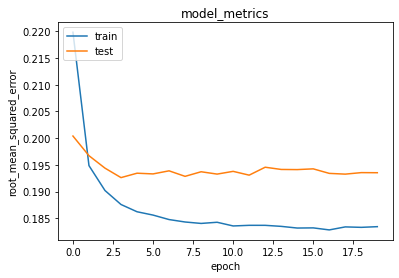

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

> Berdasarkan hasil grafik visualisasi di atas, maka dapat disimpulkan bahwa proses training model cukup smooth dan model konvergen pada epochs sekitar 10. Dari proses ini, diperoleh nilai error akhir sebesar sekitar 0.183 dan error pada data validasi sebesar 0.194. Nilai tersebut cukup bagus untuk collaborative sistem yang dibuat. Kemudian mari kita cek hasil rekomendasi model.

### Hasil collaborative recommendation

> Pertama, mari buat daftar movie yang belum pernah ditonton oleh pengguna dengan sampel pengguna akan diambil secara acak.

In [ ]:
user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]

movie_not_watched = collaborative[~collaborative['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

> Kemudian mari dapatkan hasil rekomendasi dengan menggunakan fungsi predict

In [ ]:
recommendation_results = model.predict(user_movie_array).flatten()

top_recommendation_results_indices = recommendation_results.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_recommendation_results_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movies[movies['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(f'Title : {row.title}, Genres : {row.genres}')

print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)

recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(f'Title : {row.title}, Genres : {row.genres}')

38/38 [==============================] - 0s 1ms/step
Showing recommendations for users: 474
Movie with high ratings from user
--------------------------------
Title : Sound of Music, The (1965), Genres : Musical|Romance
Title : Life Is Beautiful (La Vita è bella) (1997), Genres : Comedy|Drama|Romance|War
Title : King and I, The (1956), Genres : Drama|Musical|Romance
Title : Lord of the Rings: The Fellowship of the Ring, The (2001), Genres : Adventure|Fantasy
Title : Harry Potter and the Goblet of Fire (2005), Genres : Adventure|Fantasy|Thriller|IMAX
--------------------------------
Top 10 movie recommendation
--------------------------------
Title : Bound (1996), Genres : Crime|Drama|Romance|Thriller
Title : High Plains Drifter (1973), Genres : Western
Title : Drunken Master (Jui kuen) (1978), Genres : Action|Comedy
Title : Hedwig and the Angry Inch (2000), Genres : Comedy|Drama|Musical
Title : Fantastic Mr. Fox (2009), Genres : Adventure|Animation|Children|Comedy|Crime
Title : Intouch

> Jika dilihat dari genre movie, genre movie yang direkomendasikan lumayan mirip dengan movie yang diberi rating tinggi oleh pengguna sehingga dapat disimpulkan bahwa collaborative recommendation yang dibuat cukup memuaskan.